# Finite grammar
## Rule
Rules are used by graph parser to create no nodes.

In [1]:
from estnltk.finite_grammar import Rule

Rule(lhs='A',
     rhs=['B', 'C', 'REP(F)'], # or 'B C REP(F)'
     priority=0, # the default
     group=None, # the default
     decorator=None, # the default
     validator=None, # the default
     scoring=None # the default
    )

A -> B C REP(F)	: 0, val: default_validator, dec: default_decorator, scoring: default_scoring

group is a hashable, used to resolve support conflicts. By default, every rule has a unique group. Different nodes created by the same rule are in the same group.

decorator, validator and scoring are methods that take one argument, the support. The support is a list of nodes parsed by the rule.

decorator returns a dict with attributes for the new node, by default empty dict.

validator returns True or False. Default is True. If False, the node is not created.

scoring gives value for the score attribute of the new node, used to resolve start-end and terminals conflicts. Should be orderable.

## Grammar
Grammar is a container for rules.

In [2]:
from estnltk.finite_grammar import Rule, Grammar

grammar = Grammar(start_symbols=['S'], 
                  rules=None, # the default, deprecated
                  depth_limit=float('inf'), # the default
                  width_limit=float('inf'), # the default
                  legal_attributes=None # the default
                 )
grammar.add(Rule('S', 'A A'))
grammar.add(Rule('A', 'B C'))
grammar.add(Rule('A', 'B F'))
grammar.add(Rule('S', 'I SEQ(G)'))
grammar.add(Rule('S', 'F G H'))
grammar.add(Rule('S', 'K'))

grammar


Grammar:
	start: S
	terminals: B, C, F, G, H, I, K
	nonterminals: A, S, SEQ(G)
	legal attributes: frozenset()
	depth_limit: inf
	width_limit: inf
Rules:
	S -> A A	: 0, val: default_validator, dec: default_decorator, scoring: default_scoring
	A -> B C	: 0, val: default_validator, dec: default_decorator, scoring: default_scoring
	A -> B F	: 0, val: default_validator, dec: default_decorator, scoring: default_scoring
	S -> I SEQ(G)	: 0, val: default_validator, dec: default_decorator, scoring: default_scoring
	S -> F G H	: 0, val: default_validator, dec: default_decorator, scoring: default_scoring
	S -> K	: 0, val: default_validator, dec: default_decorator, scoring: default_scoring

Test if the height of the parse tree is finite even on an infinite graph. That is, there is no rules with loops like

```
    A -> B F
    F -> A
```

In [3]:
grammar.has_finite_max_depth()

True

## Phrase list generator
Generates all phrases of the finite grammar.

In [4]:
from estnltk.finite_grammar import phrase_list_generator

for phrase in phrase_list_generator(grammar=grammar,
                                    depth_limit=None,  # the default
                                    width_limit=4,     # default: None
                                    expand_seq=None    # the default
                                   ):
    print(phrase)

('B', 'C', 'B', 'C')
('B', 'C', 'B', 'F')
('B', 'F', 'B', 'C')
('B', 'F', 'B', 'F')
('I', 'G')
('I', 'G', 'G')
('I', 'G', 'G', 'G')
('F', 'G', 'H')
('K',)


If `depth_limit` is `None`, `grammar.depth_limit` is used. <br>
If `width_limit` is `None`, `grammar.width_limit` is used. <br>
`expand_seq` is the maximum number of descendants that a SEQ rule can have. If `width_limit==3` then 

    S -> I SEQ(G) 
translates to 

     S -> I G
     S -> I G G
     S -> I G G G
Either `width_limit` or  `expand_seq` must be a positive integer.

## Fingerprinting
Create an ngram fingerprint for the grammar output phrases.

In [5]:
from estnltk.finite_grammar import grammar_phrase_ngrams

grammar_phrase_ngrams(n=2,
                      grammar=grammar,
                      depth_limit=None,  # the default
                      width_limit=4,     # deafult: None
                      expand_seq=None    # the default
                     )

[{'I-G'}, {'K'}, {'B-C', 'C-B'}, {'B-F', 'F-B'}, {'F-G', 'G-H'}]

`n` is the maximal length of the ngram grammar symbol tuple. If the grammar output phrase is shorter, then the ngram symbol tuple is also shorter (`'K'` in this example).

## Graph from layer

In [6]:
from estnltk import Text
from estnltk import Layer
from estnltk import Span

text = Text('a b c d e f g h i j k l m')

layer = Layer(name='test_grammar',
              attributes=['grammar_symbol']
              )
layer.add_span(Span( 0,  1, legal_attributes=['grammar_symbol'], grammar_symbol='A'))
layer.add_span(Span( 2,  3, legal_attributes=['grammar_symbol'], grammar_symbol='B'))
layer.add_span(Span( 4,  5, legal_attributes=['grammar_symbol'], grammar_symbol='C'))
layer.add_span(Span( 6,  7, legal_attributes=['grammar_symbol'], grammar_symbol='D'))
layer.add_span(Span( 8,  9, legal_attributes=['grammar_symbol'], grammar_symbol='E'))
layer.add_span(Span(10, 11, legal_attributes=['grammar_symbol'], grammar_symbol='F'))
layer.add_span(Span(12, 13, legal_attributes=['grammar_symbol'], grammar_symbol='G'))
layer.add_span(Span(14, 15, legal_attributes=['grammar_symbol'], grammar_symbol='H'))
layer.add_span(Span(16, 17, legal_attributes=['grammar_symbol'], grammar_symbol='I'))
layer.add_span(Span(18, 19, legal_attributes=['grammar_symbol'], grammar_symbol='J'))
layer.add_span(Span(20, 21, legal_attributes=['grammar_symbol'], grammar_symbol='K'))
layer.add_span(Span(22, 23, legal_attributes=['grammar_symbol'], grammar_symbol='L'))
layer.add_span(Span(24, 25, legal_attributes=['grammar_symbol'], grammar_symbol='M'))

text['test_grammar'] = layer
text.test_grammar

Layer(name=test_grammar, spans=SL[Span(a, {'grammar_symbol': 'A'}),
Span(b, {'grammar_symbol': 'B'}),
Span(c, {'grammar_symbol': 'C'}),
Span(d, {'grammar_symbol': 'D'}),
Span(e, {'grammar_symbol': 'E'}),
Span(f, {'grammar_symbol': 'F'}),
Span(g, {'grammar_symbol': 'G'}),
Span(h, {'grammar_symbol': 'H'}),
Span(i, {'grammar_symbol': 'I'}),
Span(j, {'grammar_symbol': 'J'}),
Span(k, {'grammar_symbol': 'K'}),
Span(l, {'grammar_symbol': 'L'}),
Span(m, {'grammar_symbol': 'M'})])

Create a graph that represents the layer.

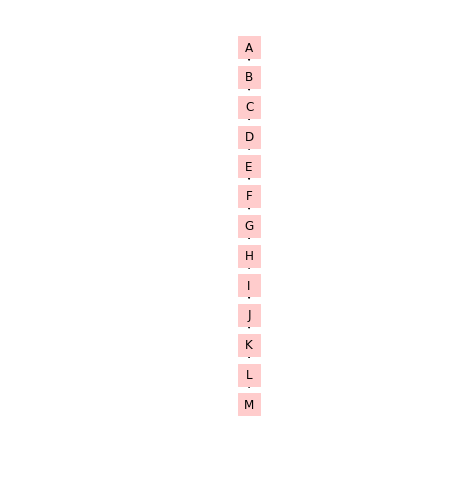

In [7]:
from estnltk.finite_grammar import layer_to_graph, plot_graph
from estnltk.finite_grammar import parse_graph

graph = layer_to_graph(layer=text['test_grammar'], raw_text=text.text, name_attribute='grammar_symbol')
plot_graph(graph,6)

## Parse
Use grammar to parse the graph above. Don't solve conflicts between the nodes.

In [8]:
class CountingDecorator:
    __name__ = 'counting_decorator'

    _count = 0

    def __call__(self, support):
        self._count += 1
        return {'count': self._count}

counting_decorator = CountingDecorator()

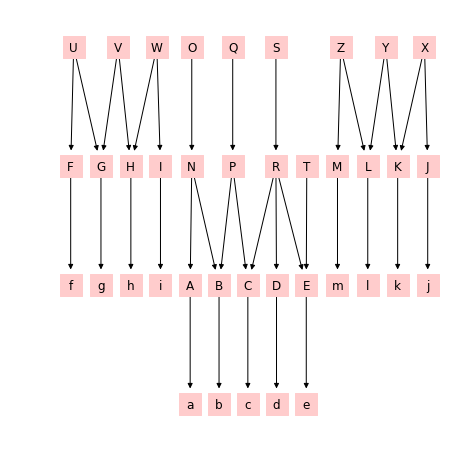

In [9]:
grammar = Grammar(start_symbols=['P', 'Q', 'S', 'U', 'Z'], legal_attributes=['count'])

grammar.add(Rule('N', 'A B',   priority=2, group='g1', decorator=CountingDecorator()))
grammar.add(Rule('O', 'N',     priority=0, group='g1', decorator=CountingDecorator()))
grammar.add(Rule('P', 'B C',   priority=1, group='g1', decorator=CountingDecorator()))
grammar.add(Rule('Q', 'P',     priority=5, group='g1', decorator=CountingDecorator()))
grammar.add(Rule('R', 'C D E', priority=1, group='g1', decorator=CountingDecorator()))
grammar.add(Rule('S', 'R',     priority=3, group='g2', decorator=CountingDecorator()))
grammar.add(Rule('T', 'E',     priority=2, group='g2', decorator=CountingDecorator()))
grammar.add(Rule('U', 'F G',   priority=1, group='g1', decorator=CountingDecorator()))
grammar.add(Rule('V', 'G H',   priority=2, group='g1', decorator=CountingDecorator()))
grammar.add(Rule('W', 'H I',   priority=3, group='g1', decorator=CountingDecorator()))
grammar.add(Rule('X', 'J K',   priority=3, group='g1', decorator=CountingDecorator()))
grammar.add(Rule('Y', 'K L',   priority=2, group='g1', decorator=CountingDecorator()))
grammar.add(Rule('Z', 'L M',   priority=1, group='g1', decorator=CountingDecorator()))


graph = layer_to_graph(text['test_grammar'], text.text)
parse_graph(graph,
            grammar,
            depth_limit=None, # the default
            width_limit=None, # the default
            resolve_support_conflicts=False,  # default: True
            resolve_start_end_conflicts=False,  # default: True
            resolve_terminals_conflicts=False,  # default: True
            ignore_validators=False, # the default
            debug=False # the default
           )

plot_graph(graph.parse_trees, 6)

## Parse repetitions
The `REP(.)` and `SEQ(.)` symbols are equivalent and help to parse repetitions in the graph. Both parse one or more repetitions of the symbol in the parentheses.

In [10]:
text_2 = Text('a b c c c d')

layer_2 = Layer(name='test_grammar',
                attributes=['grammar_symbol']
               )
layer_2.add_span(Span( 0,  1, legal_attributes=['grammar_symbol'], grammar_symbol='A'))
layer_2.add_span(Span( 2,  3, legal_attributes=['grammar_symbol'], grammar_symbol='B'))
layer_2.add_span(Span( 4,  5, legal_attributes=['grammar_symbol'], grammar_symbol='C'))
layer_2.add_span(Span( 6,  7, legal_attributes=['grammar_symbol'], grammar_symbol='C'))
layer_2.add_span(Span( 8,  9, legal_attributes=['grammar_symbol'], grammar_symbol='C'))
layer_2.add_span(Span(10, 11, legal_attributes=['grammar_symbol'], grammar_symbol='D'))

text_2['test_grammar'] = layer_2

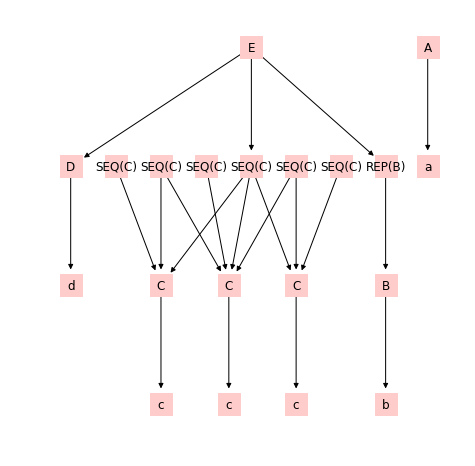

In [11]:
grammar_2 = Grammar(start_symbols=['E'])

grammar_2.add(Rule('E', 'REP(B) SEQ(C) D', priority=3, group='g1'))
graph_2 = layer_to_graph(text_2['test_grammar'], text.text)
parse_graph(graph_2,
            grammar_2,
            resolve_support_conflicts=False,
            resolve_start_end_conflicts=False,
            resolve_terminals_conflicts=False,
            width_limit=10,
            debug=False)

plot_graph(graph_2.parse_trees, 6)

## LayerGraph

In [12]:
graph_2

node type,name,start,end
TerminalNode,A,0,1
TerminalNode,B,2,3
PlusNode,REP(B),2,3
NonTerminalNode,E,2,11
TerminalNode,C,4,5
PlusNode,SEQ(C),4,5
PlusNode,SEQ(C),4,7
PlusNode,SEQ(C),4,9
TerminalNode,C,6,7
PlusNode,SEQ(C),6,7


In [13]:
nodes = sorted(graph_2)
nodes

[TerminalNode(A, (0, 1), 8866432011884846135),
 TerminalNode(B, (2, 3), -7518039863772628413),
 PlusNode(REP(B), (2, 3), 7868137376555013160),
 NonTerminalNode(E, (2, 11), 1136753974405612640),
 TerminalNode(C, (4, 5), 8636567728696475748),
 PlusNode(SEQ(C), (4, 5), 1516033841054501662),
 PlusNode(SEQ(C), (4, 7), -5966779087474551050),
 PlusNode(SEQ(C), (4, 9), -6643164903255626526),
 TerminalNode(C, (6, 7), -2711917264981931352),
 PlusNode(SEQ(C), (6, 7), -5814942428830990326),
 PlusNode(SEQ(C), (6, 9), -866122451455337770),
 TerminalNode(C, (8, 9), -3647440017068913300),
 PlusNode(SEQ(C), (8, 9), -6009152159512770810),
 TerminalNode(D, (10, 11), -4697413585455359087)]

In [14]:
nodes[7]

PlusNode(SEQ(C), (4, 9), -6643164903255626526)

## Resolve conflicts
### Support conflicts
Two nodes are in 'support' conflict if they have intersecting supports and the same group but different priorities. The node with the higher priority (smaller value) is kept.

Use the same grammar to parse the same graph as above, but also resolve the conflicts. 

Note that
1. P and N are in conflict. Priority of N is lower and so N and O are removed despite the fact that O has the highest priority among N, O, P and Q.
2. P and R are in conflict, but priorities of P and R are equal, so none of them is removed.
3. R and T are in different groups and therefore not in conflict.
4. S and T are not in conflict.
5. The conflicts between U, V and W can be solved in two ways. The remaining nodes can be U and W or U alone. The outcome is not defined. The same holds for X, Y and Z.

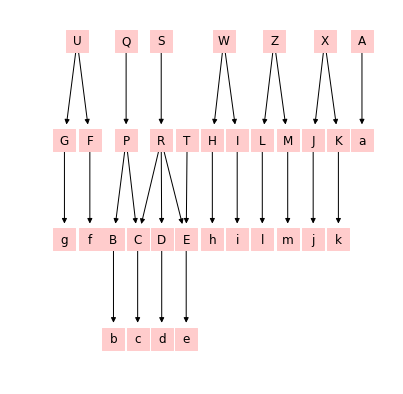

In [15]:
graph = layer_to_graph(text['test_grammar'], text.text)
parse_graph(graph, grammar, debug=False)

parse_graph(graph,
            grammar,
            resolve_support_conflicts=True,
            resolve_start_end_conflicts=False,
            resolve_terminals_conflicts=False
            )


plot_graph(graph.parse_trees, 5)

### Terminals conflict and start-end conflict

Again we start with an example graph.

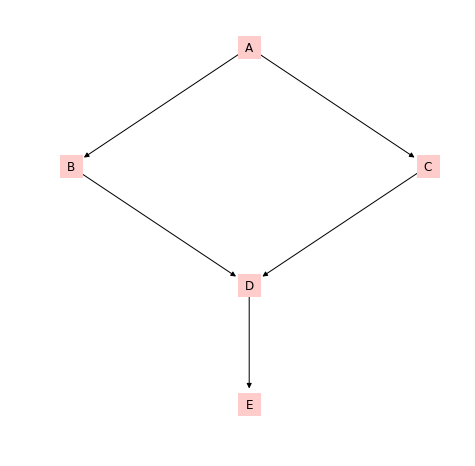

In [16]:
text = Text('a b c d e')

layer = Layer(name='test_grammar',
              attributes=['grammar_symbol'],
              ambiguous=True
              )
layer.add_span(Span( 0,  1, legal_attributes=['grammar_symbol'], grammar_symbol='A'))
layer.add_span(Span( 2,  3, legal_attributes=['grammar_symbol'], grammar_symbol='B'))
layer.add_span(Span( 2,  3, legal_attributes=['grammar_symbol'], grammar_symbol='C'))
layer.add_span(Span( 4,  5, legal_attributes=['grammar_symbol'], grammar_symbol='D'))
layer.add_span(Span( 8,  9, legal_attributes=['grammar_symbol'], grammar_symbol='E'))

text['test_grammar'] = layer
graph = layer_to_graph(text['test_grammar'], text.text)
plot_graph(graph, 6)

Here the nodes B and C have the same start and end values, but are based on different spans.

In [17]:
grammar = Grammar()
grammar.add(Rule('N', 'A B', scoring=lambda x: 2))
grammar.add(Rule('N', 'A C', scoring=lambda x: 3))
grammar.add(Rule('O', 'D E', scoring=lambda x: 4))
grammar.add(Rule('P', 'D E', scoring=lambda x: 5))
grammar.add(Rule('P', 'O',   scoring=lambda x: 6))

Turn off all conflict resolving.

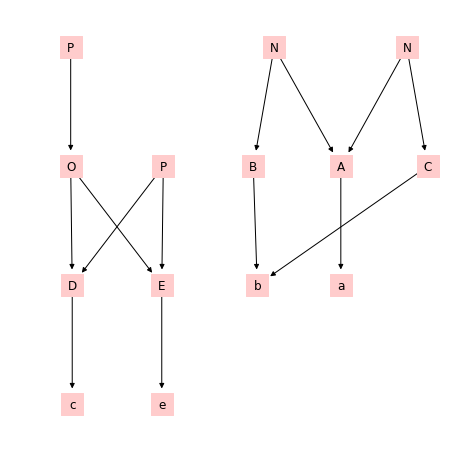

In [18]:
graph = layer_to_graph(text['test_grammar'], text.text)
parse_graph(graph,
            grammar,
            depth_limit=None,
            width_limit=None,
            resolve_support_conflicts=False,
            resolve_start_end_conflicts=False,
            resolve_terminals_conflicts=False,
            ignore_validators=False,
            debug=False)
plot_graph(graph.parse_trees, 6)

Two nodes are in 'start-end' conflict if they have the same start, end and name but different score.
The node with the higher score value is kept.

Two nodes are in 'terminals' conflict if they have the same terminals and name but different score.
The node with the higher score value is kept.

If `resolve_terminals_conflicts` is `True`, then the value of `resolve_start_end_conflicts` has no effect.

For equal scores/priorities both nodes are kept.

Above the nodes `N` and `N` are in start-end conflict, but not in terminals conflict. The nodes `P` and `P` are in start-end conflict as well as in terminals conflict. Next we turn on the start-end conflict resolving. By default, all nodes have different group and the same priority, so there is no support conflicts.

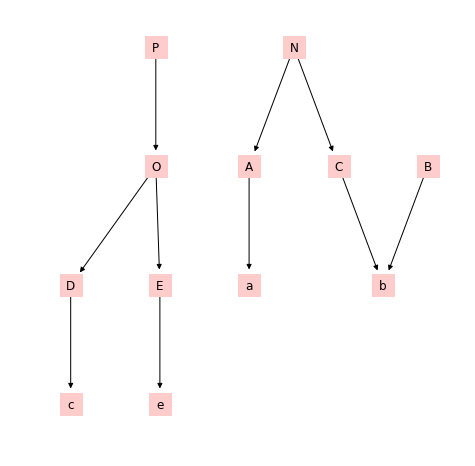

In [19]:
graph = layer_to_graph(text['test_grammar'], text.text)
parse_graph(graph,
            grammar,
            resolve_support_conflicts=False,
            resolve_start_end_conflicts=True,
            resolve_terminals_conflicts=True
           )
plot_graph(graph.parse_trees, 6)

## Grammar parsing tagger
Grammar parsing tagger converts an input layer to a graph, parses the graph using a grammar and finally converts the graph to an output layer.

In [20]:
text = Text('a b c')

layer = Layer(name='test_layer',
              attributes=['grammar_symbol']
              )
layer.add_span(Span(0,  1, legal_attributes=['grammar_symbol'], grammar_symbol='A'))
layer.add_span(Span(2,  3, legal_attributes=['grammar_symbol'], grammar_symbol='B'))
layer.add_span(Span(4,  5, legal_attributes=['grammar_symbol'], grammar_symbol='C'))

text['test_layer'] = layer
text.test_layer

Layer(name=test_layer, spans=SL[Span(a, {'grammar_symbol': 'A'}),
Span(b, {'grammar_symbol': 'B'}),
Span(c, {'grammar_symbol': 'C'})])

In [21]:
def decorator(support):
    return {'span_count': sum(len(s.terminals) for s in support)}

grammar = Grammar(start_symbols=['S', 'E'], legal_attributes={'span_count'})

grammar.add(Rule('S', 'A', decorator=decorator))
grammar.add(Rule('S', 'B', decorator=decorator))
grammar.add(Rule('D', 'B C', decorator=decorator))
grammar.add(Rule('E', 'D', decorator=decorator))

grammar


Grammar:
	start: S, E
	terminals: A, B, C
	nonterminals: D, E, S
	legal attributes: frozenset({'span_count'})
	depth_limit: inf
	width_limit: inf
Rules:
	S -> A	: 0, val: default_validator, dec: decorator, scoring: default_scoring
	S -> B	: 0, val: default_validator, dec: decorator, scoring: default_scoring
	D -> B C	: 0, val: default_validator, dec: decorator, scoring: default_scoring
	E -> D	: 0, val: default_validator, dec: decorator, scoring: default_scoring

In [22]:
from estnltk.taggers import GrammarParsingTagger
tagger = GrammarParsingTagger(grammar=grammar,
                              layer_of_tokens='test_layer',
                              name_attribute='grammar_symbol', # the default
                              layer_name='parse', # the default
                              attributes=['span_count', 'name', '_priority_', '_group_'], # default: ()
                              output_nodes=None, # by default grammar.start_symbols are used
                              resolve_support_conflicts=True, # the default
                              resolve_start_end_conflicts=True, # the default
                              resolve_terminals_conflicts=True, # the default
                              output_ambiguous=False # default False
                              )
tagger

GrammarParsingTagger(input_layers=['test_layer'], output_layer=parse, output_attributes=['span_count', 'name', '_priority_', '_group_'], grammar=
Grammar:
	start: S, E
	terminals: A, B, C
	nonterminals: D, E, S
	legal attribu ..., type: <class 'estnltk.finite_grammar.grammar.Grammar'>, name_attribute=grammar_symbol, output_nodes={'E', 'S'}, resolve_support_conflicts=True, resolve_start_end_conflicts=True, resolve_terminals_conflicts=True, ambiguous=False, gap_validator=None)

In [23]:
tagger.tag(text)
text.parse

Layer(name=parse, spans=SL[ES[Span(a, {'grammar_symbol': 'A'})],
ES[Span(b, {'grammar_symbol': 'B'})],
ES[Span(b, {'grammar_symbol': 'B'}),
Span(c, {'grammar_symbol': 'C'})]])

# PhraseListTagger
## Example 1

In [24]:
from estnltk import Text
text_1 = Text('Patsient lasi jalga, sest vasaku jala suure varba pika \
               painutajalihase kõõluse rebend ajas tal kopsu üle maksa.')
text_1.analyse('morphology')

Text(text="Patsient lasi jalga, sest vasaku jala suure varba pika                painutajalihase kõõluse rebend ajas tal kopsu üle maksa.")

In [25]:
from estnltk.finite_grammar import PhraseListTagger

phrase_list = [
               ('jalg'),
               ('vasak', 'jalg',),
               ('parem', 'jalg',),
               ('kops',),
               ('vasak', 'kops'),
               ('parem', 'kops'),
               ('kõõlus',),
               ('lihas',),
               ('maks',),
               ('neer',),
               ('parem', 'neer'),
               ('vasak', 'neer'),
               ('varvas',),
               ('suur', 'varvas'),
              ]

def decorator(text, span, phrase):
    return {'match': phrase, 'dfsd':None}

def validator(raw_text, span):
    return True

tagger = PhraseListTagger(layer_name='body_parts',
                          input_layer='morph_analysis',
                          input_attribute='lemma',
                          phrase_list=phrase_list,
                          attributes=('match',),
                          decorator=decorator,
                          #validator=validator,
                          conflict_resolving_strategy= 'MAX')
tagger

PhraseListTagger(attributes=('match',), conflict_resolving_strategy=MAX, decorator=<function decorator at 0x7fd007661d08>, input_attribute=lemma, input_layer=morph_analysis, layer_name=body_parts, phrase_list=14 phrases, validator=None)

In [26]:
tagger.tag(text_1)

Text(text="Patsient lasi jalga, sest vasaku jala suure varba pika                painutajalihase kõõluse rebend ajas tal kopsu üle maksa.")

In [27]:
text_1['body_parts']

Layer(name=body_parts, spans=SL[ES[AS[Span(vasaku, {'clitic': '', 'ending': '0', 'form': 'sg g', 'lemma': 'vasak', 'partofspeech': 'A', 'root': 'vasak', 'root_tokens': ('vasak',)})],
AS[Span(jala, {'clitic': '', 'ending': '0', 'form': 'sg g', 'lemma': 'jalg', 'partofspeech': 'S', 'root': 'jalg', 'root_tokens': ('jalg',)})]],
ES[AS[Span(suure, {'clitic': '', 'ending': '0', 'form': 'sg g', 'lemma': 'suur', 'partofspeech': 'A', 'root': 'suur', 'root_tokens': ('suur',)})],
AS[Span(varba, {'clitic': '', 'ending': '0', 'form': 'sg g', 'lemma': 'varvas', 'partofspeech': 'S', 'root': 'varvas', 'root_tokens': ('varvas',)})]],
ES[AS[Span(kõõluse, {'clitic': '', 'ending': '0', 'form': 'sg g', 'lemma': 'kõõlus', 'partofspeech': 'S', 'root': 'kõõlus', 'root_tokens': ('kõõlus',)})]],
ES[AS[Span(kopsu, {'clitic': '', 'ending': '0', 'form': 'adt', 'lemma': 'kops', 'partofspeech': 'S', 'root': 'kops', 'root_tokens': ('kops',)})]]])

Note that 'maksa' is not tagged. This is because Vabamorf thinks its lemma is 'maksma'.

## Example 2: postprocessing
Suppose that we want to postprocess the layer before adding it to the text object. Here we add an attribute 'latin_term' to the layer.

In [28]:
text = Text('Vasaku jala suure varba pika painutajalihase kõõluse rebend ajas patsiendi kopsu üle maksa.')
text.analyse('morphology')
latin_dict = {('suur', 'varvas'):'hallux', ('kõõlus',):'tendo', ('kops',):'pulmo'}

layer = tagger.tag(text, return_layer=True)
layer.attributes = ('match','latin_term')
for s in layer:
    s.latin_term = latin_dict[s.match]
text['body_parts'] = layer
text['body_parts']

Layer(name=body_parts, spans=SL[ES[AS[Span(suure, {'clitic': '', 'ending': '0', 'form': 'sg g', 'lemma': 'suur', 'partofspeech': 'A', 'root': 'suur', 'root_tokens': ('suur',)})],
AS[Span(varba, {'clitic': '', 'ending': '0', 'form': 'sg g', 'lemma': 'varvas', 'partofspeech': 'S', 'root': 'varvas', 'root_tokens': ('varvas',)})]],
ES[AS[Span(kõõluse, {'clitic': '', 'ending': '0', 'form': 'sg g', 'lemma': 'kõõlus', 'partofspeech': 'S', 'root': 'kõõlus', 'root_tokens': ('kõõlus',)})]],
ES[AS[Span(kopsu, {'clitic': '', 'ending': '0', 'form': 'adt', 'lemma': 'kops', 'partofspeech': 'S', 'root': 'kops', 'root_tokens': ('kops',)})]]])